In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
diabetes_patients_df = pd.read_csv("../data/raw/diabetes_drug.csv")
diabetes_patients_control_df = pd.read_csv("../data/raw/diabetes_drug_control.csv")

# Control matching with euclidean distance (greedy)

In [3]:
from tqdm import tnrange, tqdm, tqdm_notebook
from time import sleep
from scipy.spatial import distance

diabetes_patients_control_df_copy = diabetes_patients_control_df.copy()

selected_diabetes_patients_control_df = pd.DataFrame(index=np.arange(0, len(diabetes_patients_df)), columns=diabetes_patients_control_df.columns, dtype=diabetes_patients_control_df.dtypes)

for i, diabetes_row in tqdm_notebook(enumerate(diabetes_patients_df.iterrows()), total=len(diabetes_patients_df)):
    diabetes_point = [diabetes_row[1]['COUNT_CODES_BEFORE_DRUG'], diabetes_row[1]['MONTHS_CODES_BEFORE_DRUG']]
    control_points = diabetes_patients_control_df_copy[['COUNT_CODES', 'MONTHS_CODES']].values
    
    closest_control_point_index = distance.cdist([diabetes_point], control_points).argmin()
    closest_control_point = control_points[closest_control_point_index]
    closest_control_row = diabetes_patients_control_df_copy.iloc[closest_control_point_index]
        
    selected_diabetes_patients_control_df.loc[i] = closest_control_row
    diabetes_patients_control_df_copy.drop(diabetes_patients_control_df_copy.index[closest_control_point_index], inplace=True)

Widget Javascript not detected.  It may not be installed or enabled properly.


# Diabetes patients

In [4]:
diabetes_patients_df.describe()

,IND_SEQ,COUNT_DIABETES_DRUG,COUNT_CODES_BEFORE_DRUG,MONTHS_CODES_BEFORE_DRUG
count,1.456000e+04,14560.000000,14560.000000,14560.000000
mean,1.526147e+06,62.603571,75.005701,72.378975
std,9.496305e+05,81.411309,111.963583,50.018855
min,1.530000e+02,11.000000,10.000000,12.000000
25%,8.107165e+05,18.000000,21.000000,32.677419
50%,1.437466e+06,33.000000,41.000000,59.290323
75%,2.051846e+06,72.000000,83.000000,100.935484
max,4.210654e+06,1084.000000,3132.000000,302.193548


# Control patients (after selection)

In [5]:
selected_diabetes_patients_control_df.describe()

,IND_SEQ,COUNT_CODES,MONTHS_CODES
count,14560.0,14560.0,14560.000000
unique,14560.0,582.0,4781.000000
top,1835007.0,13.0,25.064516
freq,1.0,371.0,14.000000


# Code counts

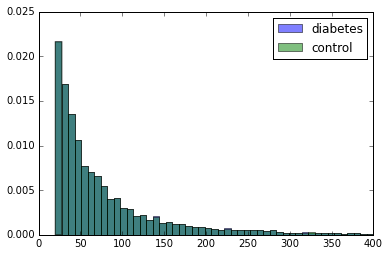

In [6]:
bins = np.linspace(20, 400, 50)

plt.hist(diabetes_patients_df['COUNT_CODES_BEFORE_DRUG'].values, bins, normed=True, alpha=0.5, label='diabetes')
plt.hist(selected_diabetes_patients_control_df['COUNT_CODES'].values, bins, normed=True, alpha=0.5, label='control')
plt.legend(loc='upper right')
plt.show()

# Number of months

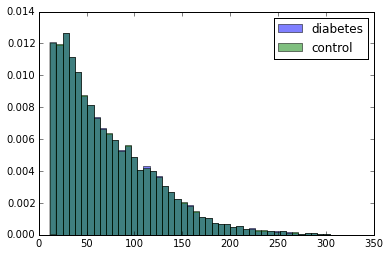

In [7]:
bins = np.linspace(12, 330, 50)

plt.hist(diabetes_patients_df['MONTHS_CODES_BEFORE_DRUG'].values, bins, normed=True, alpha=0.5, label='diabetes')
plt.hist(selected_diabetes_patients_control_df['MONTHS_CODES'].values, bins, normed=True, alpha=0.5, label='control')
plt.legend(loc='upper right')
plt.show()

# Diabetes vs. control

/Users/jacek/.pyenv/versions/3.5.0/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


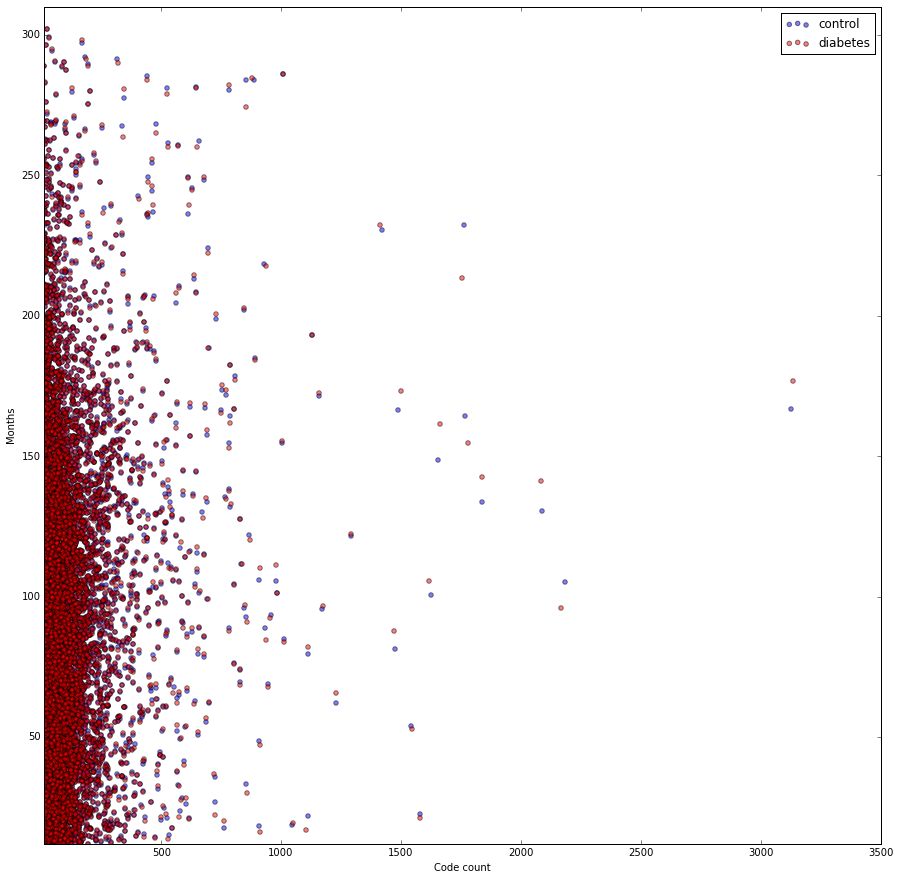

In [8]:
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

plt.scatter(selected_diabetes_patients_control_df['COUNT_CODES'].values, selected_diabetes_patients_control_df['MONTHS_CODES'].values, alpha=0.5, label='control')
plt.scatter(diabetes_patients_df['COUNT_CODES_BEFORE_DRUG'].values, diabetes_patients_df['MONTHS_CODES_BEFORE_DRUG'].values, c='red', alpha=0.5, label='diabetes')
plt.legend(loc='upper right')
plt.xlim((10,3500))
plt.xlabel('Code count')
plt.ylim((12,310))
plt.ylabel('Months')
plt.show()

# Generate final patient list

In [9]:
import datetime

final_diabetes_patients_df = diabetes_patients_df.rename(columns={
    'COUNT_CODES_BEFORE_DRUG': 'COUNT_CODES', 
    'MONTHS_CODES_BEFORE_DRUG': 'MONTHS_CODES',
    'FIRST_DIABETES_DRUG': 'CUTOFF_DATE'})
final_diabetes_patients_df.drop(["COUNT_DIABETES_DRUG"], axis=1, inplace=True)

selected_diabetes_patients_control_df["IND_SEQ"] = selected_diabetes_patients_control_df["IND_SEQ"].astype(int)
final_diabetes_patients_df["OUTCOME"] = np.ones(len(final_diabetes_patients_df), dtype=np.int)
selected_diabetes_patients_control_df["OUTCOME"] = np.zeros(len(selected_diabetes_patients_control_df), dtype=np.int)
selected_diabetes_patients_control_df["CUTOFF_DATE"] = [datetime.datetime.now().strftime("%Y-%m-%d")]*len(selected_diabetes_patients_control_df)

final_patient_list = pd.concat([final_diabetes_patients_df, selected_diabetes_patients_control_df], ignore_index=True)
final_patient_list.drop(["COUNT_CODES", "MONTHS_CODES"], axis=1, inplace=True)
final_patient_list.to_csv("../data/intermediate/patient_list.csv", index=False)